ML ШИФТ

[JINT] (SHIFT-64009) Пашина Алёна

# Описание задачи

Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить 'таблетку'. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить, кому конкретно принадлежит 'след' прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько новых - не больше 10%).

'8 утра понедельник, турникет 4? Директор.' '11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.'  Какие есть паттерны в настоящих данных?

**Цель** - предсказать, кто вошел в здание по времени и турникету.

**Описание данных**

В обучающей выборке:

* `user_id` - ID посетителя
* `ts` - дата и время прохождения через турникет
* `gate_id` - ID турникета

В тестовой выборке `user_id` заменены на слова: `aucroc, binary, blue, categorical` и т.п.

Требуется составить таблицу вида:

| user_word | preds |
| --- | --- |
| aucroc | 50 |
| binary | 11 |
| blue | -999 |
| ... | ... |

* `user_word` - закодированные ID пользователей
* `preds` - предсказанные ID
* `-999` - ID нового посетителя, которого раньше не было

Таблицу нужно запомнить как `csv` и потом заархивировать в `zip` архив. 

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать ID. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее отгадали слово, тем больше баллов.

Посетителей здания будем считать сотрудниками некой компании.

# Импорт библиотек

In [14]:
import pandas as pd
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (roc_auc_score, 
                             f1_score,
                             roc_curve, 
                             accuracy_score, 
                             ConfusionMatrixDisplay, 
                             confusion_matrix, 
                             recall_score,
                             precision_score)
from sklearn.inspection import permutation_importance
from catboost import (CatBoostClassifier,
                        Pool,
                        EShapCalcType,
                        EFeaturesSelectionAlgorithm)

import shap
import loguru
import plotly
import phik
import zipfile
import io
import re
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution
import optuna
from scipy.stats import mode

In [15]:
# sklearn.set_config(transform_output="pandas")
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

RANDOM_STATE = 42

In [16]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# Первичный анализ и предобработка данных

In [17]:
df_train = pd.read_csv('../data/train.csv', index_col=[0], parse_dates=[2])
df_test = pd.read_csv('../data/test.csv', index_col=[0], parse_dates=[1])
ex_submit = pd.read_csv('../data/submit.csv')

In [18]:
for name, df in zip(['тренировочная выборка', 'тестовая выборка', 'пример решения'], [df_train, df_test, ex_submit]):
    print(f'\033[1m{name}:\033[0m')
    display(df)
    print(f'\033[1mобщая информация - {name}:\033[0m')
    df.info()
    print(f'\033[1mколичество пропусков: {df.isna().sum().sum()}\033[0m')
    print(f'\033[1mколичество явных дубликатов: {df.duplicated().sum()}\033[0m')
    print()

тренировочная выборка:


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


общая информация - тренировочная выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB
количество пропусков: 0
количество явных дубликатов: 2346

тестовая выборка:


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


общая информация - тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB
количество пропусков: 0
количество явных дубликатов: 505

пример решения:


,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,12
7,epsilon,1
8,f1,37
9,fit,3


общая информация - пример решения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
количество пропусков: 0
количество явных дубликатов: 0



Пропусков в данных не обнаружено.

В тренировочной и тестовой выборке есть явные дубликаты, удалим их.

In [19]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

In [20]:
df_train.shape

(35172, 3)

In [21]:
df_test.shape

(6620, 3)

Предоставлены данные за 7 месяцев - с июля 2022 по фефраль 2023. Номер месяца в качестве признака не подойдет.

ID сотрудников

In [22]:
# активность сотрудников в train
df_train.user_id.value_counts(ascending=True).to_frame()

,count
user_id,
4,1
51,2
44,4
21,5
52,5
30,10
5,10
38,13
10,17


In [23]:
df_test.user_word.value_counts(ascending=True).to_frame().sort_index().index

Index(['aucroc', 'binary', 'blue', 'categorical', 'coefficient', 'collinear',
       'distributed', 'epsilon', 'f1', 'fit', 'gini', 'independent', 'lasso',
       'linear', 'logistic', 'loss', 'matrix', 'minimization', 'mse', 'ols',
       'precision', 'predict', 'pvalue', 'r2', 'recall', 'regression',
       'residual', 'ridge', 'sigmoid', 'significant', 'target', 'tstat', 'x',
       'y'],
      dtype='object', name='user_word')

Удалим из трейна и теста юзеров, для которых мы уверенно делаем предсказания

In [24]:
u_id = [24, 12, 14, 0, 1, 6, 15, 17, 19, 43, 11, 39, 32, 54, 3, 35, 55, 33, 46, 9, 37, 49, 29]
u_word = [
    'aucroc', 'binary', 'categorical', 'distributed', 'epsilon', 'f1', 'gini', 'linear', 'loss', 'mse', 'ols', 
    'predict', 'pvalue', 'r2', 'recall', 'ridge', 'sigmoid', 'significant', 'target', 'tstat', 'x',
    'y',
    'independent', 'matrix'
]

In [25]:
len(u_id)

23

In [26]:
len(u_word)

24

In [27]:
df_train = df_train[~df_train['user_id'].isin(u_id)]
df_train.shape

(9231, 3)

In [28]:
df_test = df_test[~df_test['user_word'].isin(u_word)]
df_test.shape

(1010, 3)

In [29]:
print(f'Количество сотрудников в train: {df_train.user_id.nunique()}')

Количество сотрудников в train: 33


In [30]:
print(sorted(df_train['user_id'].unique()))

[2, 4, 5, 7, 8, 10, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 38, 40, 41, 42, 44, 45, 47, 48, 50, 51, 52, 53, 56, 57]


In [31]:
df_train.user_id.value_counts(ascending=True).to_frame()

,count
user_id,
4,1
51,2
44,4
52,5
21,5
30,10
5,10
38,13
10,17


Исходя из графиков посещений здания для каждого сотрудника, исключим некоторых из тренировочной выборки.

In [32]:
[2, 4, 5, 7, 8, 10, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 34, 36, 38, 40, 41, 42, 44, 45, 47, 48, 49, 50, 51, 52, 53, 56, 57]

[2,
 4,
 5,
 7,
 8,
 10,
 18,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 34,
 36,
 38,
 40,
 41,
 42,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 56,
 57]

In [33]:
delete_user_id = [4, 20, 21, 44, 51, 52]
len(delete_user_id)

6

In [34]:
df_train = df_train[~df_train['user_id'].isin(delete_user_id)]
df_train.shape

(9102, 3)

In [35]:
df_train['user_id'].nunique()

27

In [36]:
print(f'Количество сотрудников в test: {df_test.user_word.nunique()}')

Количество сотрудников в test: 10


In [37]:
# активность сотрудников в test
df_test.user_word.value_counts(ascending=True).to_frame()

,count
user_word,
logistic,5
blue,12
lasso,33
regression,50
precision,54
coefficient,56
minimization,95
fit,183
residual,224


Турникеты

In [38]:
print(f'Количество турникетов в train: {len(df_train.gate_id.unique())}')
# частота использования турникетов в train
count_gate_id_train = df_train.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_train.T

Количество турникетов в train: 16


gate_id,0,16,1,8,-1,15,12,9,13,6,7,11,5,10,3,4
count,2,3,5,9,11,29,248,374,374,498,756,963,1041,1071,1597,2121


In [39]:
print(f'Количество турникетов в test: {len(df_test.gate_id.unique())}')
# частота использования турникетов в test
count_gate_id_test = df_test.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_test.T

Количество турникетов в test: 11


gate_id,8,1,13,6,9,7,5,11,10,3,4
count,1,1,2,41,56,95,104,128,134,198,250


In [40]:
# id турникетов, которые есть в train, но нет в test
set(df_train.gate_id.unique()) - set(df_test.gate_id.unique())

{-1, 0, 12, 15, 16}

In [41]:
# id турникетов, которые есть в test, но нет в train
set(df_test.gate_id.unique()) - set(df_train.gate_id.unique())

set()

Поскольку `gate_id` мы будем использовать в качестве признака, редкие категории (менее 5 записей) нужно удалить.

In [42]:
delete_gate_id = set(count_gate_id_train.query('count < 5').index) | set(count_gate_id_test.query('count < 5').index)
delete_gate_id = [-1, 0, 1, 2, 14, 16]

In [43]:
df_train = df_train.query('gate_id not in @delete_gate_id').reset_index(drop=True)
df_test = df_test.query('gate_id not in @delete_gate_id').reset_index(drop=True)

# Генерирование признаков

In [44]:
def make_features(df):
    df = df.loc[:]
    # отсортируем датафрейм для удобства генерирования признаков
    # потом отсортируем только по дате
    df = df.sort_values(['user_id', 'ts']).reset_index(drop=True)
    # временные признаки
    df['date'] = df.ts.dt.normalize()
    df['day_of_month'] = df.ts.dt.day
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    df['week_number'] = df.ts.dt.isocalendar().week             # неделя начинается с пн. Вспомогательный признак
    df['day_of_week'] = df.ts.dt.dayofweek                      # 0 = пн.
    df['is_weekend'] = df.day_of_week >= 5
    df['time_of_day'] = np.select(
            condlist=[df['hour'] < 6, df['hour'] < 12, df['hour'] < 18],
            choicelist=['night', 'morning', 'afternoon'],
            default='evening',
    )       # время суток
    df['is_month_start'] = df['ts'].dt.is_month_start
    df['is_month_end'] = df['ts'].dt.is_month_end

    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # число проходов сотрудником ч/з турникуты в день
    df['pass_cnt_per_day'] = grouped_data['gate_id'].transform('size')
    # число проходов через конкретный турникет в конкретный день
    df['daily_gate_pass_count'] = df.groupby(['user_id', 'date', 'gate_id'])['gate_id'].transform('size')
    # вероятность прохода через конкретный турникет в конкретный день
    df['probability_gate_id'] = df['daily_gate_pass_count'] / df['pass_cnt_per_day']
    # количество сотрудников, вошедших в конкретный день в здание
    df['cnt_users_per_day'] = df.groupby('date')['user_id'].transform('nunique')
    # количество сотрудников, вошедших в конкретную неделю в здание
    df['cnt_users_per_week'] = df.groupby('week_number')['user_id'].transform('nunique')
    # индекс дневной явки сотрудника
    df['daily_attendance_index'] = df['cnt_users_per_day'] / df['cnt_users_per_week']
    # количество дней в конкретную неделю, в которые сотрудник заходил в здание
    df['cnt_days_per_week'] = df.groupby(['user_id', 'week_number'])['date'].transform('nunique')

    # время прихода на работу (количество минут от полуночи)
    df['entry_time'] = grouped_data['ts'].transform('min')
    df['entry_time'] = ((df['entry_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # время ухода с работы (количество минут от полуночи)
    df['exit_time'] = grouped_data['ts'].transform('max')
    df['exit_time'] = ((df['exit_time'] - df['date']).dt.total_seconds() // 60).astype('int')   # Вспомогательный признак
    # продолжительность рабочего времени в минутах
    df['working_time_per_day'] = df['exit_time'] - df['entry_time']
    # турникет, через который сотрудник зашел в здание в конкретный день
    df['entrance_gate_id'] = grouped_data['gate_id'].transform('first')
    # турникет, через который сотрудник вышел из здания в конкретный день
    df['exit_gate_id'] = grouped_data['gate_id'].transform('last')
    # продолжительность рабочего времени за неделю в минутах (working_time_per_week)
    df_working_time_per_week = df.groupby(['user_id', 'date'], as_index=False)[['week_number', 'working_time_per_day']].first()
    df_working_time_per_week = df_working_time_per_week.groupby(['user_id', 'week_number'], as_index=False)['working_time_per_day'].sum()
    df_working_time_per_week = df_working_time_per_week.rename(columns={'working_time_per_day': 'working_time_per_week'})
    df = pd.merge(df, df_working_time_per_week, on=['user_id', 'week_number'], how='left')
    # индекс дневной нагрузки сотрудника - отношение минут работы за день к минутам работы за неделю
    df['daily_workload_index'] = df['working_time_per_day'] / df['working_time_per_week']
    # на случай, когда working_time_per_day = 0 и working_time_per_week = 0
    df['daily_workload_index'] = df['daily_workload_index'].fillna(0)

    for i in range(1, 6):
        # 5 предыдущих турникетов
        df[f'gate_id_lag_{i}'] = grouped_data['gate_id'].shift(i, fill_value=-100)
        # 5 последующих турникетов
        df[f'gate_id_{i}'] = grouped_data['gate_id'].shift(-i, fill_value=-200)
        # разница в секундах между текущей записью и пятью предыдущими
        df[f'sec_btw_lag_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(i)
        df[f'sec_btw_lag_{i}'] = df[f'sec_btw_lag_{i}'].fillna(-1000).astype('int')
        # разница в секундах между текущей записью и пятью следующими
        df[f'sec_btw_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(-i)
        df[f'sec_btw_{i}'] = df[f'sec_btw_{i}'].fillna(1000).astype('int')

    # метка gate_id, совпадающего с предыдущим, промежуток между срабатываниями равен 1 секунде
    df['repeat_gate_1s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(1)
    # -//- 2 секундам
    df['repeat_gate_2s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(2)
    # -//- 3 секундам
    df['repeat_gate_3s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(3)
    # -//- 4 секундам
    df['repeat_gate_4s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(4)
    # -//- от 5 секунд
    df['repeat_gate_ge_5s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].ge(5)
    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # количество повторных срабатываний турникетов для user_id в конкретный день, промежуток между срабатываниями равен 1 секунде
    df['cnt_repeat_gate_1s'] = grouped_data['repeat_gate_1s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_2s'] = grouped_data['repeat_gate_2s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_3s'] = grouped_data['repeat_gate_3s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_4s'] = grouped_data['repeat_gate_4s'].transform('sum')
    # -//- от 5 секунд
    df['cnt_repeat_gate_ge_5s'] = grouped_data['repeat_gate_ge_5s'].transform('sum')

    # маршрут – содержит информацию о соседних турникетах, через которые прошел сотрудник (направление не учитывается)
    df['route'] = df.apply(lambda row: str(sorted([row['gate_id_lag_1'], row['gate_id']])), axis=1)
    # если сотрудник пришел с улицы
    df.loc[df['route'].str.contains('-100'), 'route'] = 'not_route'

    # вспомогательный признак
    df['temp_sec_btw_lag_1'] = df['sec_btw_lag_1']
    # если сотрудник пришел с улицы
    df.loc[df['temp_sec_btw_lag_1'] < 0, 'temp_sec_btw_lag_1'] = 0
    # накопленное время нахождения в здании к моменту прохода через турникет в течение дня
    df['cumtime_per_day'] = df.groupby(['user_id', 'date'])['temp_sec_btw_lag_1'].cumsum()
    # накопленное время нахождения на конкретном маршруте в течение дня
    df['cumtime_at_route_per_day'] = df.groupby(['user_id', 'date', 'route'])['temp_sec_btw_lag_1'].cumsum()

    # самый часто используемый турникет за день
    df['most_frequent_gate_per_day'] = df.groupby(['user_id', 'date'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет за неделю
    df['most_frequent_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за день
    df['most_frequent_route_per_day'] = df.groupby(['user_id', 'date'])['route'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за неделю
    df['most_frequent_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform(lambda x: x.value_counts().idxmax())

    # среднее время, затраченное на маршрут в течение недели
    df['weekly_route_avg_time'] = df.groupby(['user_id', 'week_number', 'route'])['temp_sec_btw_lag_1'].transform('mean')
    # среднее время, затраченное на маршрут
    df['route_avg_time'] = df.groupby(['user_id', 'route'])['temp_sec_btw_lag_1'].transform('mean')

    return df

In [45]:
df_train = make_features(df_train)
df_train.head(3)

,user_id,ts,gate_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
0,2,2022-12-28 14:22:24,5,2022-12-28,28,14,862,51744,52,2,False,afternoon,False,False,11,2,0.18,5,6,0.83,3,862,1131,269,5,4,1321,0.20,-100,5,-1000,-2,-100,4,-1000,-17,-100,4,-1000,-19,-100,3,-1000,-7896,-100,3,-1000,-7898,False,False,False,False,False,1,3,0,0,1,not_route,0,0,0,4,4,"[4, 4]","[4, 4]",0.00,0.00
1,2,2022-12-28 14:22:26,5,2022-12-28,28,14,862,51746,52,2,False,afternoon,False,False,11,2,0.18,5,6,0.83,3,862,1131,269,5,4,1321,0.20,5,4,2,-15,-100,4,-1000,-17,-100,3,-1000,-7894,-100,3,-1000,-7896,-100,10,-1000,-7911,False,True,False,False,False,1,3,0,0,1,"[5, 5]",2,2,2,4,4,"[4, 4]","[4, 4]",1.40,1.40
2,2,2022-12-28 14:22:41,4,2022-12-28,28,14,862,51761,52,2,False,afternoon,False,False,11,4,0.36,5,6,0.83,3,862,1131,269,5,4,1321,0.20,5,4,15,-2,5,3,17,-7879,-100,3,-1000,-7881,-100,10,-1000,-7896,-100,10,-1000,-7915,False,False,False,False,False,1,3,0,0,1,"[4, 5]",15,17,15,4,4,"[4, 4]","[4, 4]",15.00,15.00


In [46]:
df_train.shape

(9081, 68)

In [47]:
# временно переименуем колонку `user_word` на `user_id`
df_test = df_test.rename(columns={'user_word': 'user_id'})

df_test = make_features(df_test)
# df_test = df_test.rename(columns={'user_id': 'user_word'})
df_test.head(3)

,ts,gate_id,user_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
0,2023-01-03 12:58:57,5,blue,2023-01-03,3,12,778,46737,1,1,False,afternoon,False,False,7,3,0.43,7,7,1.00,2,778,785,7,5,4,23,0.30,-100,5,-1000,-9,-100,5,-1000,-12,-100,10,-1000,-107,-100,11,-1000,-353,-100,4,-1000,-381,False,False,False,False,False,1,0,1,0,1,not_route,0,0,0,5,5,"[5, 5]",not_route,0.00,0.00
1,2023-01-03 12:59:06,5,blue,2023-01-03,3,12,779,46746,1,1,False,afternoon,False,False,7,3,0.43,7,7,1.00,2,778,785,7,5,4,23,0.30,5,5,9,-3,-100,10,-1000,-98,-100,11,-1000,-344,-100,4,-1000,-372,-100,4,-1000,-373,False,False,False,False,True,1,0,1,0,1,"[5, 5]",9,9,9,5,5,"[5, 5]",not_route,6.00,6.00
2,2023-01-03 12:59:09,5,blue,2023-01-03,3,12,779,46749,1,1,False,afternoon,False,False,7,3,0.43,7,7,1.00,2,778,785,7,5,4,23,0.30,5,10,3,-95,5,11,12,-341,-100,4,-1000,-369,-100,4,-1000,-370,-100,-200,-1000,1000,False,False,True,False,False,1,0,1,0,1,"[5, 5]",3,12,12,5,5,"[5, 5]",not_route,6.00,6.00


In [48]:
df_test.shape

(1009, 68)

In [49]:
df_train.isna().sum().sum()

0

In [50]:
df_test.isna().sum().sum()

0

# Исследовательский анализ данных

## Повторное срабатывание турникетов

## Количество проходов через турникеты в неделю

In [51]:
week_counts_train = df_train['week_number'].value_counts().sort_index().reset_index()

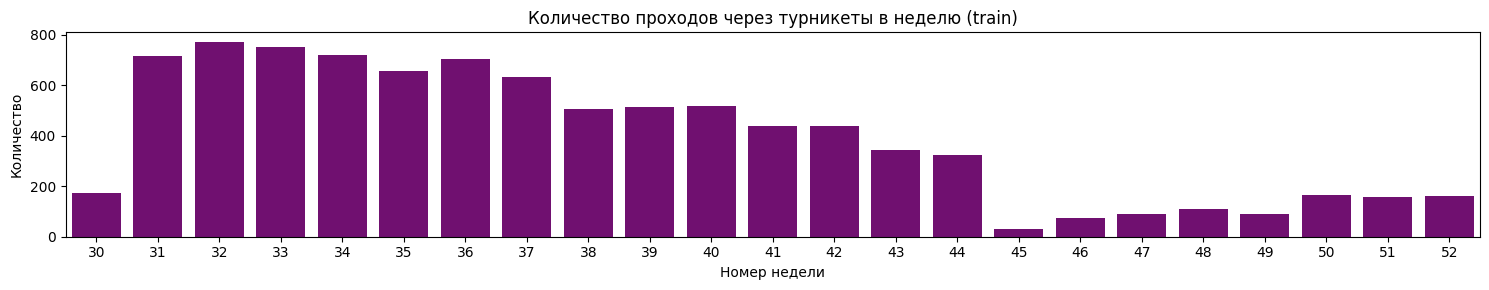

In [52]:
plt.figure(figsize=(15, 3))
sns.barplot(x='week_number', y='count', data=week_counts_train, color='purple')
plt.title('Количество проходов через турникеты в неделю (train)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [53]:
df_train.loc[df_train['week_number'] == 30, 'date'].nunique()

2

In [54]:
df_train.loc[df_train['week_number'] == 45, 'date'].nunique()

2

In [55]:
df_train.loc[df_train['week_number'] == 45, 'user_id'].unique()

array([18, 47, 50], dtype=int64)

Мы видим, что 30 неделя - неполная. Поскольку при генерировании признаков мы использовали агрегацию по номеру недели, удалим данные за 30 неделю из тренировочной выборки.

In [56]:
df_train.shape

(9081, 68)

In [57]:
df_train = df_train.query('week_number > 30 and week_number != 45').reset_index(drop=True)
df_train.shape

(8875, 68)

In [58]:
# df_train = df_train.query('week_number > 30').reset_index(drop=True)
# df_train.shape

In [59]:
df_train['user_id'].nunique()

27

In [60]:
week_counts_test = df_test['week_number'].value_counts().sort_index().reset_index()

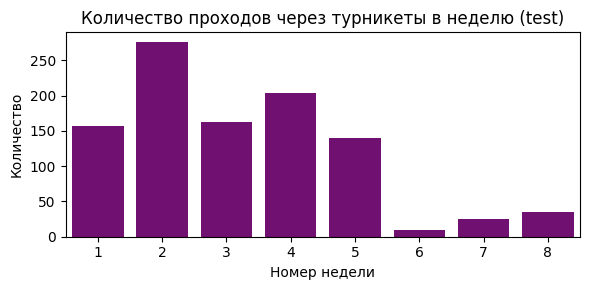

In [61]:
plt.figure(figsize=(6, 3))
sns.barplot(x='week_number', y='count', data=week_counts_test, color='purple')
plt.title('Количество проходов через турникеты в неделю (test)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [62]:
df_test.loc[df_test['week_number'] == 1, 'date'].nunique()

4

In [63]:
df_test.loc[df_test['week_number'] == 8, 'date'].nunique()

3

In [64]:
df_test.query('week_number >= 6')['user_id'].nunique()

3

Удалим из тестовой выборки данные с 6 по 8 неделю, поскольку в этот период была маленькая активность.

In [65]:
df_test.shape

(1009, 68)

In [66]:
df_test = df_test.query('week_number < 6').reset_index(drop=True)
df_test.shape

(940, 68)

In [67]:
df_test['user_id'].nunique()

10

In [68]:
df_train = df_train.sort_values('ts').reset_index(drop=True)
df_test = df_test.sort_values('ts').reset_index(drop=True)

In [69]:
# удаление вспомогательных признаков
df_train = df_train.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)
df_test = df_test.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)

In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8875 entries, 0 to 8874
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       8875 non-null   int64  
 1   gate_id                       8875 non-null   int64  
 2   day_of_month                  8875 non-null   int32  
 3   hour                          8875 non-null   int32  
 4   total_minutes                 8875 non-null   int32  
 5   total_seconds                 8875 non-null   int32  
 6   day_of_week                   8875 non-null   int32  
 7   is_weekend                    8875 non-null   bool   
 8   time_of_day                   8875 non-null   object 
 9   is_month_start                8875 non-null   bool   
 10  is_month_end                  8875 non-null   bool   
 11  pass_cnt_per_day              8875 non-null   int64  
 12  daily_gate_pass_count         8875 non-null   int64  
 13  pro

In [71]:
df_train.columns

Index(['user_id', 'gate_id', 'day_of_month', 'hour', 'total_minutes',
       'total_seconds', 'day_of_week', 'is_weekend', 'time_of_day',
       'is_month_start', 'is_month_end', 'pass_cnt_per_day',
       'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day',
       'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week',
       'entry_time', 'working_time_per_day', 'entrance_gate_id',
       'exit_gate_id', 'working_time_per_week', 'daily_workload_index',
       'gate_id_lag_1', 'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1',
       'gate_id_lag_2', 'gate_id_2', 'sec_btw_lag_2', 'sec_btw_2',
       'gate_id_lag_3', 'gate_id_3', 'sec_btw_lag_3', 'sec_btw_3',
       'gate_id_lag_4', 'gate_id_4', 'sec_btw_lag_4', 'sec_btw_4',
       'gate_id_lag_5', 'gate_id_5', 'sec_btw_lag_5', 'sec_btw_5',
       'repeat_gate_1s', 'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s',
       'repeat_gate_ge_5s', 'cnt_repeat_gate_1s', 'cnt_repeat_gate_2s',
       'cnt_repeat_gate_3s

In [72]:
categorical_features = [
       'gate_id', 'day_of_month', 'hour',
       'day_of_week', 'is_weekend', 'time_of_day', 
       'is_month_start', 'is_month_end', 'entrance_gate_id', 
       'exit_gate_id', 'gate_id_lag_1', 'gate_id_1',
       'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3',
       'gate_id_3', 'gate_id_lag_4', 'gate_id_4',
       'gate_id_lag_5', 'gate_id_5', 'repeat_gate_1s',
       'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s',
       'repeat_gate_ge_5s', 'route', 'most_frequent_gate_per_day',
       'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week'
]

## Оценка важности признаков

### Корреляция между признаками

In [73]:
# %%time
# phik_overview = df_train.phik_matrix().round(2).sort_values('user_id', ascending=False)
# phik_overview

In [74]:
# # отберем фичи, у которых корреляция с целевым признаком более 0.2
# df_train = df_train[phik_overview[phik_overview['user_id'] > 0.2].index]

In [75]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(phik_overview, vmin=0, vmax=1, cmap='Purples', annot=True, linewidths=0.1, fmt='.2f')
# plt.suptitle('Матрица Phi_K-корреляций', y=0.92);

In [76]:
# %%time
# significance_overview = df_train.significance_matrix().fillna(0).round(1).sort_values('user_id', ascending=False)
# significance_overview

In [77]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(significance_overview, vmin=-5, vmax=5, cmap='Purples', annot=True, linewidths=0.1, fmt='.1f')
# plt.suptitle('Значимость коэффициентов', y=0.92);

# Построение моделей

## Разделение исходных данных на выборки

In [78]:
y = df_train['user_id']
X = df_train.drop(['user_id'], axis=1)

In [79]:
categorical_columns = categorical_features
print(categorical_columns)

['gate_id', 'day_of_month', 'hour', 'day_of_week', 'is_weekend', 'time_of_day', 'is_month_start', 'is_month_end', 'entrance_gate_id', 'exit_gate_id', 'gate_id_lag_1', 'gate_id_1', 'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3', 'gate_id_3', 'gate_id_lag_4', 'gate_id_4', 'gate_id_lag_5', 'gate_id_5', 'repeat_gate_1s', 'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s', 'repeat_gate_ge_5s', 'route', 'most_frequent_gate_per_day', 'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week']


In [80]:
len(categorical_columns)

30

In [81]:
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(numerical_columns)

['cnt_repeat_gate_ge_5s', 'cnt_days_per_week', 'route_avg_time', 'sec_btw_lag_5', 'cumtime_at_route_per_day', 'cnt_users_per_day', 'cnt_repeat_gate_2s', 'total_seconds', 'entry_time', 'sec_btw_2', 'daily_attendance_index', 'sec_btw_4', 'daily_gate_pass_count', 'sec_btw_lag_3', 'cnt_repeat_gate_4s', 'probability_gate_id', 'working_time_per_day', 'cnt_repeat_gate_1s', 'working_time_per_week', 'daily_workload_index', 'weekly_route_avg_time', 'sec_btw_lag_4', 'sec_btw_lag_1', 'sec_btw_3', 'sec_btw_lag_2', 'cnt_repeat_gate_3s', 'total_minutes', 'cnt_users_per_week', 'cumtime_per_day', 'sec_btw_1', 'sec_btw_5', 'pass_cnt_per_day']


In [82]:
len(numerical_columns)

32

In [83]:
X = X[categorical_columns + numerical_columns]

In [84]:
# формируем массив индексов категориальных признаков
categorical_features_indices = list(range(len(categorical_columns)))
print(categorical_features_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [85]:
# выделение обучающей выборки (80 %) и тестовой (20 %)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y
)

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7100, 62), (1775, 62), (7100,), (1775,))

In [87]:
y_train.nunique()

27

In [88]:
print(sorted(y_train.unique()))

[2, 5, 7, 8, 10, 18, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 38, 40, 41, 42, 45, 47, 48, 50, 53, 56, 57]


In [89]:
y_test.nunique()

27

In [90]:
print(sorted(y_test.unique()))

[2, 5, 7, 8, 10, 18, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 38, 40, 41, 42, 45, 47, 48, 50, 53, 56, 57]


## Подбор гиперпараметров после отбора признаков

In [91]:
def fit_catboost(trial, train, val, cat_features_indices):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'n_estimators' : 2000, # Можно не перебирать, есть Early-Stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 60.0),        
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'None']),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'border_count': trial.suggest_int('border_count', 32, 128)
    }

    clf = CatBoostClassifier(
        **param,
        loss_function='MultiClass',
        eval_metric='TotalF1:average=Macro',
        random_seed=RANDOM_STATE,
        cat_features=cat_features_indices,
        thread_count=-1,
        task_type='GPU',
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=100,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [92]:
def objective(trial, X, y, cat_features_indices, return_models=False):
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scores, models = [], []
    
    for train_idx, valid_idx in skf.split(X, y):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data, cat_features_indices) # Определили выше
        scores.append(f1_score(valid_data[1], y_pred, average='macro'))
        models.append(model)
        # break
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result

In [93]:
selected_features = [
    'most_frequent_route_per_week',
    'working_time_per_week',
    'entry_time',
    'cnt_users_per_day',
    'cnt_repeat_gate_3s',
    'most_frequent_route_per_day',
    'route_avg_time',
    'daily_attendance_index',
    'cnt_repeat_gate_2s',
    'exit_gate_id',
    'daily_workload_index',
    'cnt_repeat_gate_1s',
    'entrance_gate_id',
    'working_time_per_day',
    'pass_cnt_per_day',
    'cnt_users_per_week',
    'cnt_days_per_week',
    'most_frequent_gate_per_week'
]

cat_features = [
    'most_frequent_route_per_week',
    'most_frequent_route_per_day',
    'exit_gate_id',
    'entrance_gate_id',
    'most_frequent_gate_per_week'
]

In [94]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X[selected_features], y, cat_features),
                n_trials=3,
                show_progress_bar=True,
)

[I 2024-08-15 13:30:50,066] A new study created in memory with name: no-name-aa7161e2-e83a-43bd-bc08-528bb49afbdf


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.2063685	test: 0.2012497	best: 0.2012497 (0)	total: 31.2ms	remaining: 1m 2s
100:	learn: 0.8945130	test: 0.8870631	best: 0.8870631 (100)	total: 2.04s	remaining: 38.3s
200:	learn: 0.9539732	test: 0.9431654	best: 0.9431654 (200)	total: 3.9s	remaining: 35s
300:	learn: 0.9768066	test: 0.9648691	best: 0.9649082 (293)	total: 5.71s	remaining: 32.2s
400:	learn: 0.9841619	test: 0.9782140	best: 0.9782140 (400)	total: 7.5s	remaining: 29.9s
500:	learn: 0.9922142	test: 0.9901801	best: 0.9901801 (499)	total: 9.33s	remaining: 27.9s
600:	learn: 0.9960711	test: 0.9935761	best: 0.9935761 (599)	total: 11.2s	remaining: 26s
700:	learn: 0.9974303	test: 0.9959356	best: 0.9959356 (691)	total: 13s	remaining: 24.1s
800:	learn: 0.9989144	test: 0.9975536	best: 0.9975536 (777)	total: 14.8s	remaining: 22.2s
900:	learn: 0.9992136	test: 0.9981121	best: 0.9981121 (828)	total: 16.7s	remaining: 20.3s
bestTest = 0.9981121011
bestIteration = 828
Shrink model to first 829 iterations.
0:	learn: 0.2411599	test: 0.2

In [95]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9974417468380543, params {'learning_rate': 0.03969560965592583, 'l2_leaf_reg': 3.752827058894772, 'auto_class_weights': 'Balanced', 'max_depth': 4, 'border_count': 78}


In [96]:
%%time

valid_scores, models_sf_new_fit = objective(
    optuna.trial.FixedTrial(study.best_params),
    X[selected_features], 
    y, 
    cat_features,
    return_models=True,
)

0:	learn: 0.2063685	test: 0.2012497	best: 0.2012497 (0)	total: 21.6ms	remaining: 43.2s
100:	learn: 0.8945130	test: 0.8870631	best: 0.8870631 (100)	total: 1.99s	remaining: 37.3s
200:	learn: 0.9539732	test: 0.9431654	best: 0.9431654 (200)	total: 3.94s	remaining: 35.3s
300:	learn: 0.9768066	test: 0.9648691	best: 0.9649082 (293)	total: 5.87s	remaining: 33.1s
400:	learn: 0.9841619	test: 0.9782140	best: 0.9782140 (400)	total: 7.74s	remaining: 30.9s
500:	learn: 0.9922142	test: 0.9901801	best: 0.9901801 (499)	total: 9.66s	remaining: 28.9s
600:	learn: 0.9960711	test: 0.9935761	best: 0.9935761 (599)	total: 11.6s	remaining: 27s
700:	learn: 0.9974303	test: 0.9959356	best: 0.9959356 (691)	total: 13.5s	remaining: 25.1s
800:	learn: 0.9989144	test: 0.9975536	best: 0.9975536 (777)	total: 15.5s	remaining: 23.1s
900:	learn: 0.9992136	test: 0.9981121	best: 0.9981121 (828)	total: 17.4s	remaining: 21.2s
bestTest = 0.9981121011
bestIteration = 828
Shrink model to first 829 iterations.
0:	learn: 0.2411599	tes

In [97]:
valid_scores

0.9974417468380543

In [98]:
for m in models_sf_new_fit:
    print(m.tree_count_)

829
1043
1175


In [99]:
for m in models_sf_new_fit:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3.7528271675109863, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storag

## Итоговое предсказание лучшей модели

In [100]:
def make_prediction_dict(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    result = result.groupby('user_word')['pred_user_id'].agg(lambda group: dict(group.value_counts())).to_dict()
    return result

In [101]:
def make_prediction(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    # датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id для конкретной категории user_word
    temp_1 = result.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
    # датафрейм: user_word; количество user_word
    temp_2 = result['user_word'].value_counts().reset_index(name='count_user_word')
    # датафрейм: pred_user_id; количество pred_user_id
    temp_3 = result['pred_user_id'].value_counts().reset_index(name='count_pred_user_id')
    # датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word; count_pred_user_id
    result = temp_1.merge(temp_2, on='user_word', how='left').merge(temp_3, on='pred_user_id', how='left')
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во user_word
    result['confidence_per_user_word'] = result['count_pred_user_id_in_user_word'] / result['count_user_word']
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во pred_user_id
    result['confidence_per_pred_user_id'] = result['count_pred_user_id_in_user_word'] / result['count_pred_user_id']
    # итоговая уверенность
    result['confidence'] = result['confidence_per_user_word'] + result['confidence_per_pred_user_id']
    # сортируем данные по убыванию уверенности
    result = result.sort_values(by='confidence', ascending=False)

    # формируем итоговый датафрейм
    final = pd.DataFrame(columns=['user_word', 'preds'])
    # user_word, которые уже добавлены в final
    words = set()
    # user_id, которые уже добавлены в final
    ids = set()
    # добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
    for _, row in result.iterrows():
        word, user_id = row['user_word'], row['pred_user_id']
        if word not in words and user_id not in ids and row['confidence'] > 0.1:
            final.loc[len(final)] = [word, user_id]
            words.add(word)
            ids.add(user_id)

    # категориям, насчет которых модель не уверена, проставляется -999
    for word in (set(result['user_word'].unique()) - set(final['user_word'])):
        final.loc[len(final)] = [word, -999]
    
    return final.sort_values(by='user_word')

In [102]:
df_test = df_test.rename(columns={'user_id': 'user_word'})

Сделаем предсказание

После удаления фичей, уменьшающих скор, и повторного подбора гиперпараметров

In [103]:
result_dct_sf_new_fit = make_prediction_dict(df_test, selected_features, models_sf_new_fit)
result_dct_sf_new_fit

{'blue': {36: 7, 25: 5},
 'coefficient': {18: 24, 34: 13, 27: 7, 22: 7, 25: 3, 41: 2},
 'collinear': {50: 133, 23: 58, 47: 27, 2: 16, 41: 11, 56: 7},
 'fit': {23: 166, 50: 17},
 'lasso': {41: 10, 36: 9, 25: 6, 56: 4, 30: 3, 23: 1},
 'logistic': {36: 5},
 'minimization': {50: 78, 41: 13, 30: 4},
 'precision': {41: 16, 56: 11, 23: 8, 50: 3},
 'regression': {41: 28, 22: 11, 56: 3},
 'residual': {50: 157, 48: 42, 47: 20, 25: 5}}

In [ ]:
{'blue': {56: 12},
 'coefficient': {49: 21, 26: 10, 41: 8, 18: 7, 25: 7, 40: 3},
 'collinear': {50: 144, 23: 47, 29: 40, 49: 14, 25: 7},
 'fit': {23: 160, 49: 8, 29: 8, 25: 7},
 'independent': {49: 193, 23: 27, 18: 14},
 'lasso': {25: 13, 56: 10, 41: 10},
 'logistic': {56: 5},
 'matrix': {29: 67, 50: 24, 23: 11, 41: 9, 49: 8, 56: 7, 25: 6},
 'minimization': {50: 60, 41: 30, 56: 4, 10: 1},
 'precision': {41: 16, 23: 11, 25: 11},
 'regression': {50: 14, 41: 14, 49: 14},
 'residual': {50: 106, 29: 76, 49: 22, 47: 20}}

In [ ]:
{'blue': {30: 7, 56: 5},
 'coefficient': {18: 16, 2: 12, 34: 9, 22: 9, 23: 7, 7: 3},
 'collinear': {50: 147,
  29: 42,
  23: 41,
  41: 20,
  2: 16,
  22: 9,
  38: 9,
  56: 8,
  25: 6},
 'fit': {23: 144, 2: 24, 25: 8, 50: 7},
 'independent': {49: 170, 23: 69, 26: 25, 41: 14},
 'lasso': {34: 10, 56: 8, 36: 5, 30: 5, 23: 5},
 'logistic': {36: 5},
 'matrix': {29: 46, 50: 31, 2: 19, 41: 17, 30: 16, 25: 12, 22: 9, 10: 7},
 'minimization': {50: 59, 41: 21, 10: 11, 30: 4},
 'precision': {23: 38, 25: 15},
 'regression': {41: 28, 50: 14, 56: 8},
 'residual': {50: 94, 29: 91, 47: 34, 25: 5}}

In [ ]:
{'blue': {25: 12},
 'coefficient': {18: 28, 49: 12, 41: 9, 27: 7},
 'collinear': {50: 108, 29: 97, 23: 47, 18: 20, 49: 18, 56: 8},
 'fit': {23: 157, 50: 13, 49: 8, 29: 5},
 'independent': {49: 241, 23: 21, 18: 14, 50: 2},
 'lasso': {25: 13, 18: 10, 56: 9, 23: 1},
 'logistic': {56: 5},
 'matrix': {29: 84, 49: 33, 50: 13, 2: 11, 47: 9, 27: 6, 23: 1},
 'minimization': {50: 91, 30: 4},
 'precision': {50: 52, 23: 1},
 'regression': {50: 14, 49: 14, 29: 8, 47: 8, 41: 6},
 'residual': {50: 102, 29: 85, 49: 37}}

In [104]:
result_cb_sf_new_fit = make_prediction(df_test, selected_features, models_sf_new_fit)
result_cb_sf_new_fit

,user_word,preds
8,blue,25
1,coefficient,18
4,collinear,2
0,fit,23
9,lasso,30
2,logistic,36
5,minimization,50
7,precision,56
6,regression,41
3,residual,48


In [105]:
len(result_cb_sf_new_fit)

10

Сохраненим результаты

In [302]:
# csv_buffer = io.StringIO()

# # result_cb.to_csv(csv_buffer, index=False)

# # result_cb_sf.to_csv(csv_buffer, index=False)

# result_cb_sf_new_fit.to_csv(csv_buffer, index=False)

# with zipfile.ZipFile('../data/answer.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
#     zf.writestr('answer.csv', csv_buffer.getvalue())

In [106]:
# result_cb.to_csv('../data/submit_cb_v_05_all.csv', index=False)

# result_cb_sf.to_csv('../data/submit_cb_v_05_sf.csv', index=False)

result_cb_sf_new_fit.to_csv('../data/experiment_04.csv', index=False)

# Сравнение ответов

In [107]:
right_answers = pd.read_csv(r'E:\projects\SHIFT\предыдущие_наработки\right_answers.csv')
res_ivan = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\1) 04_02_2024\answer_ivan.csv')
res_vera = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\4) Ivanova_Vera_SaintPetersburg 358\shift_ml-main\answer_vera.csv')
res_cb_01 = pd.read_csv('../data/experiment_01.csv')
res_cb_02 = pd.read_csv('../data/experiment_02.csv')
res_cb_03 = pd.read_csv('../data/experiment_03.csv')
res_cb_04 = pd.read_csv('../data/experiment_04.csv')

In [108]:
u_w = res_cb_04.user_word.unique()
u_w

array(['blue', 'coefficient', 'collinear', 'fit', 'lasso', 'logistic',
       'minimization', 'precision', 'regression', 'residual'],
      dtype=object)

In [110]:
res = right_answers.loc[:].rename(columns={'preds': 'right_answers'}).query('user_word in @u_w').reset_index(drop=True)
res['right_answers'] = res['right_answers'].apply(lambda x: f'{x:.0f}')
res['ivan'] = res_ivan.query('user_word in @u_w').reset_index(drop=True)['preds']
res['vera'] = res_vera.query('word in @u_w').reset_index(drop=True)['preds']
res['cb_v_01'] = res_cb_01.query('user_word in @u_w').reset_index(drop=True)['preds']
res['cb_v_02'] = res_cb_02.query('user_word in @u_w').reset_index(drop=True)['preds']
res['cb_v_03'] = res_cb_03.query('user_word in @u_w').reset_index(drop=True)['preds']
res['cb_v_04'] = res_cb_04['preds']

In [111]:
# Функция для условного форматирования
def highlight_matching_cells(x):
    ref_col = x['vera']
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for col in x.columns:
        if col == 'right_answers':
            df_styled[col] = ['background-color: red' if x[col].iloc[i] != 'nan' else '' for i in range(len(x))]
        elif col != 'vera':
            df_styled[col] = ['background-color: green' if x[col].iloc[i] == ref_col.iloc[i] else '' for i in range(len(x))]
    return df_styled

# Применение стиля
res.style.apply(highlight_matching_cells, axis=None)

,user_word,right_answers,ivan,vera,cb_v_01,cb_v_02,cb_v_03,cb_v_04
0,blue,nan,-999,56,25,30,56,25
1,coefficient,nan,-999,27,18,18,26,18
2,collinear,nan,-999,23,-999,38,50,2
3,fit,nan,23,6,23,23,23,23
4,lasso,nan,36,25,-999,34,25,30
5,logistic,nan,-999,31,56,36,-999,36
6,minimization,nan,50,48,50,50,10,50
7,precision,nan,-999,8,-999,25,41,56
8,regression,nan,-999,-999,47,41,-999,41
9,residual,nan,-999,47,29,47,47,48


# The end